
# House Prices — Task 8 Feature Engineering & Modeling
This notebook completes the Internship Task 08 using the provided **House Prices - Advanced Regression Techniques** dataset.

It covers:
- Loading and exploring the data
- Handling missing values
- Feature engineering (new features, encoding, transformations)
- Training a RandomForest baseline model
- Cross-validation performance (RMSE)
- Feature importance inspection
- Making predictions on the test set and saving a submission file

---


In [2]:

# Step 1 — Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, PowerTransformer

pd.set_option('display.max_columns', 200)
sns.set_style('whitegrid')


In [3]:

# Step 2 — Load data
train = pd.read_csv("C:\\Users\\admin\\OneDrive\\Desktop\\skillyt\\house\\train.csv")
test = pd.read_csv("C:\\Users\\admin\\OneDrive\\Desktop\\skillyt\\house\\test.csv")
sample_sub = pd.read_csv("C:\\Users\\admin\\OneDrive\\Desktop\\skillyt\\house\\sample_submission.csv")

print('Train shape:', train.shape)
print('Test shape:', test.shape)
train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Target SalePrice distribution:


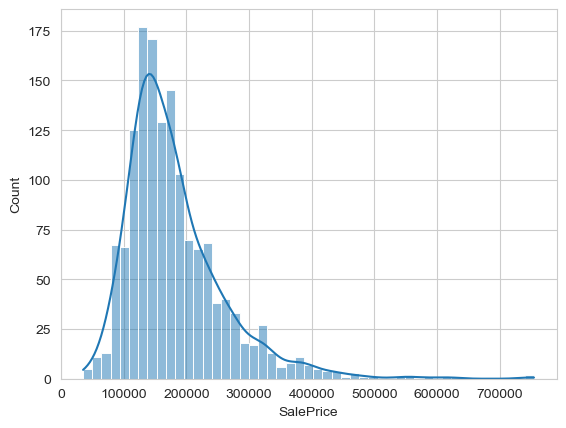


Missing values (top 20):


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64

In [4]:

# Step 3 — Quick EDA
print('Target SalePrice distribution:')
sns.histplot(train['SalePrice'], kde=True)
plt.show()

print('\nMissing values (top 20):')
na = train.isnull().sum().sort_values(ascending=False)
na = na[na > 0]
display(na.head(20))



## Feature Engineering Plan
1. Create meaningful new features (TotalSF, Age, HasGarage, etc.).
2. Fill missing values sensibly (domain-aware).
3. Encode categorical variables (ordinal mappings + one-hot/label encoding).
4. Fix skewness with transformations.
5. Train a RandomForest baseline with cross-validation.


In [6]:

# Step 4 — Feature engineering function
def prepare_data(df):
    df = df.copy()
    if 'Id' in df.columns:
        df.drop('Id', axis=1, inplace=True)
    
    # Feature creation
    if {'TotalBsmtSF','1stFlrSF','2ndFlrSF'}.issubset(df.columns):
        df['TotalSF'] = df['TotalBsmtSF'].fillna(0) + df['1stFlrSF'].fillna(0) + df['2ndFlrSF'].fillna(0)
    if {'YearBuilt','YrSold'}.issubset(df.columns):
        df['HouseAge'] = df['YrSold'] - df['YearBuilt']
    if {'YearRemodAdd','YrSold'}.issubset(df.columns):
        df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    if 'PoolArea' in df.columns:
        df['HasPool'] = (df['PoolArea'].fillna(0) > 0).astype(int)
    if 'GarageArea' in df.columns:
        df['HasGarage'] = (df['GarageArea'].fillna(0) > 0).astype(int)
    if 'TotalBsmtSF' in df.columns:
        df['HasBsmt'] = (df['TotalBsmtSF'].fillna(0) > 0).astype(int)
    
    # Fill missing categorical with 'None'
    none_cols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
                 'GarageType','GarageFinish','GarageQual','GarageCond',
                 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']
    for c in none_cols:
        if c in df.columns:
            df[c] = df[c].fillna('None')
    
    # Fill missing numeric with 0 for area-like
    zero_cols = ['MasVnrArea','GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2',
                 'BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']
    for c in zero_cols:
        if c in df.columns:
            df[c] = df[c].fillna(0)
    
    # LotFrontage fill by neighborhood median
    if 'LotFrontage' in df.columns and 'Neighborhood' in df.columns:
        df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
        df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())
    
    # Fill remaining missing numerics with median
    for c in df.select_dtypes(include=[np.number]).columns:
        if df[c].isnull().sum() > 0:
            df[c] = df[c].fillna(df[c].median())
    
    # Fill remaining categoricals with mode
    for c in df.select_dtypes(include=['object']).columns:
        if df[c].isnull().sum() > 0:
            df[c] = df[c].fillna(df[c].mode()[0])
    
    # Ordinal encoding for quality
    qual_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'None':0}
    qual_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC',
                 'KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
    for c in qual_cols:
        if c in df.columns:
            df[c] = df[c].map(qual_map).fillna(0).astype(int)
    
    # One-hot for categoricals with small cardinality
    cat_cols = [c for c in df.select_dtypes(include=['object']).columns if df[c].nunique() <= 15]
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    
    # Label encode high cardinality
    le = LabelEncoder()
    for c in df.select_dtypes(include=['object']).columns:
        df[c] = le.fit_transform(df[c].astype(str))
    
    return df


In [7]:

# Step 5 — Apply feature engineering
train_prep = prepare_data(train)
test_prep  = prepare_data(test)
print('Prepared train shape:', train_prep.shape)
print('Prepared test shape:', test_prep.shape)


Prepared train shape: (1460, 199)
Prepared test shape: (1459, 196)


In [8]:

# Step 6 — Transform target and skewed features
from scipy import stats

train_prep['SalePrice_orig'] = train_prep['SalePrice']
train_prep['SalePrice'] = np.log1p(train_prep['SalePrice'])

# Skewness correction
numeric_feats = train_prep.drop(columns=['SalePrice','SalePrice_orig']).select_dtypes(include=[np.number]).columns
skewed = train_prep[numeric_feats].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
skewed_feats = skewed[abs(skewed) > 0.75].index

pt = PowerTransformer(method='yeo-johnson', standardize=False)
for feat in skewed_feats:
    combined = np.concatenate([train_prep[feat].values, test_prep[feat].values])
    transformed = pt.fit_transform(combined.reshape(-1,1)).reshape(-1)
    train_prep[feat] = transformed[:train_prep.shape[0]]
    test_prep[feat]  = transformed[train_prep.shape[0]:]
    
print("Applied log1p to target and transformed skewed features.")


Applied log1p to target and transformed skewed features.


In [9]:

# Step 7 — Baseline RandomForest with CV
X = train_prep.drop(['SalePrice','SalePrice_orig'], axis=1)
y = train_prep['SalePrice']

common_cols = X.columns.intersection(test_prep.columns)
X = X[common_cols]
test_X = test_prep[common_cols]

model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1)
rmse_scores = np.sqrt(scores)

print('CV RMSE (log target):', rmse_scores)
print('Mean CV RMSE:', rmse_scores.mean())

model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(20)


CV RMSE (log target): [0.14659875 0.12682483 0.17437705 0.1455452  0.12293531]
Mean CV RMSE: 0.14325622738403707


OverallQual     0.444314
TotalSF         0.314680
CentralAir_Y    0.018113
GrLivArea       0.014760
GarageCars      0.013699
LotArea         0.011093
BsmtFinSF1      0.011028
GarageArea      0.010568
OverallCond     0.010158
RemodAge        0.008378
HouseAge        0.008086
BsmtUnfSF       0.007522
1stFlrSF        0.007403
YearBuilt       0.006427
GarageYrBlt     0.006211
LotFrontage     0.005747
Neighborhood    0.005490
YearRemodAdd    0.005386
KitchenQual     0.005036
2ndFlrSF        0.004727
dtype: float64

In [10]:

# Step 8 — Predictions on test set and submission file
preds_log = model.predict(test_X)
preds = np.expm1(preds_log)

submission = sample_sub.copy()
submission['SalePrice'] = preds
submission.to_csv('submission.csv', index=False)
print('Saved submission.csv')
submission.head()


Saved submission.csv


,Id,SalePrice
0,1461,125729.683143
1,1462,153037.361666
2,1463,175235.831067
3,1464,182575.741784
4,1465,194235.058677



---
## Next Steps
- Try different models (XGBoost, LightGBM, CatBoost) and hyperparameter tuning.
- Blend/stack models for improved accuracy.
- Use domain insights to engineer better features (e.g., interactions, area per room, etc.).
